<a href="https://colab.research.google.com/github/ominivac/analise_integraSUS/blob/master/Analise_de_dados_do_IntegraSUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [89]:
import plotly
import numpy as np
import plotly.offline as py
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline
import matplotlib.pyplot as plt

In [90]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/IntegraSUS/casos_coronavirus_2020_09_02.csv", low_memory=False)

In [147]:
#quantidade de registros
df.shape

(765013, 46)

In [148]:
df.dtypes

Unnamed: 0                                   int64
codigoPaciente                              object
paisPaciente                                object
estadoPaciente                              object
codigoMunicipioPaciente                    float64
municipioPaciente                           object
bairroPaciente                              object
sexoPaciente                                object
idadePaciente                              float64
dataNotificacao                     datetime64[ns]
dataSolicitacaoExame                datetime64[ns]
dataResultadoExame                  datetime64[ns]
dataColetaExame                     datetime64[ns]
resultadoFinalExame                         object
obitoConfirmado                             object
dataInicioSintomas                  datetime64[ns]
dataObito                           datetime64[ns]
idSivep                                    float64
classificacaoEstadoSivep                    object
dataInternacaoSivep            

In [149]:
df.head(5)

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
0,0,4b672a7843721a0019381cc839fcd71a,NaN,CE,231090.0,PIQUET CARNEIRO,DISTRITO IBICUA,MASCULINO,43.0,2020-07-09,NaT,NaT,NaT,NaN,NaN,2020-07-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,6389090,PIQUET CARNEIRO,0,0,40-59
1,1,88afda26fcf0146e14b04daadbb71d3f,NaN,CE,230500.0,GUARACIABA DO NORTE,ZONA RURAL,FEMININO,3.0,2020-08-05,NaT,NaT,NaT,NaN,NaN,2020-08-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2561344,GUARACIABA DO NORTE,0,0,0-9
2,2,2e4b50fb6e54d98c210d335ca9652676,NaN,CE,230680.0,JAGUARIBARA,CONJ FELICIA,FEMININO,16.0,2020-07-29,NaT,NaT,NaT,NaN,NaN,2020-07-26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2527677,JAGUARIBARA,0,0,10-19
3,3,307e78273c1f690632ddddaf4366c713,NaN,CE,230440.0,FORTALEZA,CONJUNTO PALMEIRAS,MASCULINO,61.0,2020-07-29,2020-07-29,2020-07-31 16:06:00,2020-07-29,Negativo,NaN,2020-07-29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,7429398,FORTALEZA,0,0,60-79
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26 00:00:00,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59


In [150]:
# Tranformar as col. de data no tipo certo
df[["dataNotificacao","dataSolicitacaoExame","dataResultadoExame","dataColetaExame","dataInicioSintomas", "dataObito", "dataNotificacaoObito"]] =  df[["dataNotificacao","dataSolicitacaoExame","dataResultadoExame","dataColetaExame","dataInicioSintomas", "dataObito", "dataNotificacaoObito"]].apply(pd.to_datetime,  errors='coerce')

In [151]:
# Algumas colunas em brancos, contar para sexoPaciente
count = df["sexoPaciente"].isnull().sum()
print(count)

4168


**Salvar com separator ';' pro tableau**

In [152]:
#df.to_csv('/content/drive/My Drive/IntegraSUS/casos_coronavirus_2020_08_16_tableau.csv', sep=';', encoding='UTF-8', index=False)

In [153]:
# Contar para todas colunas quantas registros em branco
df.isna().sum()

Unnamed: 0                               0
codigoPaciente                           0
paisPaciente                        681081
estadoPaciente                       11982
codigoMunicipioPaciente              19313
municipioPaciente                    11633
bairroPaciente                       77999
sexoPaciente                          4168
idadePaciente                         4106
dataNotificacao                     103422
dataSolicitacaoExame                615414
dataResultadoExame                  121005
dataColetaExame                     104534
resultadoFinalExame                 101681
obitoConfirmado                     755921
dataInicioSintomas                  111155
dataObito                           754273
idSivep                             736698
classificacaoEstadoSivep            740113
dataInternacaoSivep                 740075
dataEntradaUtisSvep                 758627
dataSaidaUtisSvep                   762076
evolucaoCasoSivep                   745438
dataEvoluca

In [154]:
 # Saída para registros com exames positivos
df[df['resultadoFinalExame'] == 'Positivo'].head()

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59
7,7,f633b38785e0bbb0da5064d311ec174d,NaN,CE,230440.0,FORTALEZA,CAMBEBA,FEMININO,48.0,2020-05-21,NaT,2020-05-25,2020-05-22,Positivo,NaN,2020-05-18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Amarela,NaT,3012778,FORTALEZA,0,1,40-59
10,10,99d0d41c7b822ba907e71edd4b1ed255,NaN,CE,231095.0,PIRES FERREIRA,MARROCOS,FEMININO,3.0,2020-08-24,NaT,2020-08-25,2020-08-25,Positivo,NaN,2020-08-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,6614221,PIRES FERREIRA,0,1,0-9
16,16,d732bc739e8a931f25d4e76525ce1f9b,NaN,CE,230290.0,CAPISTRANO,ZONA RURAL,FEMININO,28.0,2020-08-05,NaT,2020-08-11,2020-08-11,Positivo,NaN,2020-08-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,\t2327872,CAPISTRANO,0,1,20-39
19,19,6bbbd16692086a4e7ccf0748eb6f3e56,NaN,CE,230440.0,FORTALEZA,MEIRELES,MASCULINO,47.0,2020-05-03,NaT,2020-05-09,2020-05-07,Positivo,NaN,2020-04-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,980016277569495,FORTALEZA,0,1,40-59


In [155]:
df[df['dataObito'].notnull()]

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
196,196,e49ca4b4153fee1ca1955086e46194a7,NaN,CE,230440.0,FORTALEZA,CRISTO REDENTOR,MASCULINO,54.0,2020-05-15,2020-05-15,2020-06-02 17:14:31,2020-05-15 06:00:00,Negativo,NaN,2020-05-12,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-06-11 09:38:45.110,7434308,FORTALEZA,0,0,40-59
981,981,07c59fc7f348ffe9e5e73977412809af,NaN,CE,230765.0,MARACANAU,JEREISSATE 2,FEMININO,78.0,2020-05-25,2020-05-27,2020-05-28 21:09:25,2020-05-25 09:00:00,Negativo,NaN,2020-05-18,2020-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-05-27 13:00:30.927,NaN,MARACANAU,0,0,60-79
1082,1082,aa61c7071f7a6cac0f9f5fc8d5086008,NaN,CE,230770.0,MARANGUAPE,UMARIZEIRAS,FEMININO,69.0,2020-04-21,2020-04-22,2020-04-24 20:21:07,2020-04-21 12:00:00,Negativo,NaN,2020-04-18,2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-05-20 17:28:42.393,5345243,MARANGUAPE,0,0,60-79
2854,2854,b12278515abb9dc50c2bd7eb2a5d0e7a,BRASIL,CE,230770.0,MARANGUAPE,NaN,FEMININO,65.0,2020-05-30,2020-06-01,2020-06-05 15:57:50,2020-06-01 06:00:00,Positivo,True,2020-05-27,2020-06-14,3.159216e+11,Positivo,2020-05-31 00:00:00.000,2020-05-31 00:00:00.000,2020-06-02 00:00:00.000,Óbito,2020-06-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Não Informado,2020-06-15 11:07:06.913,2554798,MARANGUAPE,1,0,60-79
2920,2920,48d852bd2f0076810e50c3830c2b364c,NaN,CE,230495.0,GUAIÚBA,CHICO DE GOES,MASCULINO,90.0,2020-05-20,2020-05-20,2020-06-09 17:14:23,2020-05-20 09:00:00,Positivo,True,2020-05-08,2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-05-20 11:48:16.310,6433952,GUAIUBA,1,0,80E+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760633,760633,a14b91177969e3457979cfc35a22661e,NaN,CE,230350.0,CASCAVEL,CENTRO,MASCULINO,90.0,2020-05-24,NaT,NaT,2020-05-24 06:00:00,Positivo,True,2020-05-18,2020-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-06-14 15:14:28.867,190124514450007,CASCAVEL,1,0,80E+
760665,760665,5527aae144ee27baa9146d16d66e5c48,NaN,CE,230440.0,FORTALEZA,MONTESE,MASCULINO,88.0,2020-08-02,2020-08-02,2020-08-04 12:22:53,2020-08-03 03:00:00,Negativo,NaN,2020-08-02,2020-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-08-17 14:02:12.800,7514948,FORTALEZA,0,0,80E+
760833,760833,7f0a3470a831a43ae84d09c23142decb,BRASIL,CE,230440.0,FORTALEZA,MONTESE,MASCULINO,98.0,2020-05-20,NaT,NaT,2020-05-20 03:00:00,NaN,False,2020-05-18,2020-05-29,3.159182e+11,Em Análise,2020-05-19 00:00:00.000,NaN,NaN,Óbito,2020-05-29 00:00:00.000,Não,Sim,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,Em investigação,Não Informado,Não Informado,2020-06-12 14:55:20.873,7514948,FORTALEZA,0,0,80E+

In [156]:
# Saída para registros sem óbito
df[ df['obitoConfirmado'] == False ]

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
4838,4838,152fd68edcc6ee699df8a2ed16c8c433,BRASIL,CE,230440.0,FORTALEZA,SAO JOAO DO TAUAPE,MASCULINO,72.0,2020-05-06,2020-05-06,NaT,2020-05-06 09:00:00,NaN,False,2020-04-22,2020-05-09,3.159300e+11,Em Análise,2020-05-04 00:00:00.000,NaN,NaN,Óbito,2020-05-09 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-05-20 17:36:38.930,9526293,FORTALEZA,0,0,60-79
7847,7847,464ea2ffbf7f2cf494208eb35ff3dbc0,NaN,CE,230440.0,FORTALEZA,PRESIDENTE KENNEDY,MASCULINO,66.0,2020-05-07,NaT,NaT,NaT,NaN,False,2020-05-02,2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-06-03 10:02:07.837,NaN,FORTALEZA,0,0,60-79
16712,16712,21c7f56bc0d816645b35245fb55fc83a,NaN,CE,230765.0,MARACANAU,ACARACUZINHO,MASCULINO,62.0,2020-05-07,NaT,NaT,2020-05-10 06:00:00,NaN,False,2020-04-30,2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Não Informado,2020-05-20 17:37:18.820,NaN,MARACANAU,0,0,60-79
19887,19887,42a865af783ece72700c6367ce4ba746,NaN,CE,230440.0,FORTALEZA,PARQUE ARAXÁ,MASCULINO,36.0,2020-04-12,NaT,NaT,2020-04-12 06:00:00,NaN,False,2020-04-10,2020-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Não Informado,2020-06-15 09:49:19.250,3242587,FORTALEZA,0,0,20-39
22413,22413,dc759a1c64f6156ec947b7719c22a77a,NaN,CE,230765.0,MARACANAU,TIMBO,FEMININO,57.0,2020-06-27,NaT,NaT,NaT,NaN,False,2020-05-07,2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-06-29 14:49:53.687,2806215,FORTALEZA,0,0,40-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738719,738719,2bffd75bd6bb9b8fa3d1e82159c506ee,NaN,CE,230765.0,MARACANAU,NOVO MARACANAU,FEMININO,53.0,2020-06-26,NaT,NaT,NaT,NaN,False,2020-05-16,2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Branca,2020-05-20 19:30:03.750,2806215,FORTALEZA,0,0,40-59
741933,741933,8dc30b2bcbad1e960ee46fd291a5468d,NaN,CE,230440.0,FORTALEZA,MONTESE,FEMININO,82.0,2020-05-20,NaT,2020-05-22,NaT,NaN,False,2020-05-17,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-06-16 09:56:04.090,3012778,FORTALEZA,0,0,80E+
744497,744497,70069bed5f07d0e64786d27c6ba5e53e,NaN,CE,230765.0,MARACANAU,CENTRO,MASCULINO,91.0,2020-06-27,NaT,NaT,NaT,NaN,False,2020-04-30,2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-05-20 23:27:10.100,2806215,FORTALEZA,0,0,80E+
745277,745277,cd77224f4288f33e2f747cc85b9f5c26,NaN,CE,230440.0,FORTALEZA,HENRIQUE JORGE,MASCULINO,55.0,2020-04-28,NaT,2020-04-28,2020-04-29 03:00:00,NaN,False,2020-04-17,2020-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [157]:
# Casos onde o resutado do exame foi positivo e não resultou em óbito
df[ (df['resultadoFinalExame'] == 'Positivo') & (df['dataObito'].isnull()) ]

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26 00:00:00,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59
7,7,f633b38785e0bbb0da5064d311ec174d,NaN,CE,230440.0,FORTALEZA,CAMBEBA,FEMININO,48.0,2020-05-21,NaT,2020-05-25 00:00:00,2020-05-22,Positivo,NaN,2020-05-18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Amarela,NaT,3012778,FORTALEZA,0,1,40-59
10,10,99d0d41c7b822ba907e71edd4b1ed255,NaN,CE,231095.0,PIRES FERREIRA,MARROCOS,FEMININO,3.0,2020-08-24,NaT,2020-08-25 00:00:00,2020-08-25,Positivo,NaN,2020-08-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,6614221,PIRES FERREIRA,0,1,0-9
16,16,d732bc739e8a931f25d4e76525ce1f9b,NaN,CE,230290.0,CAPISTRANO,ZONA RURAL,FEMININO,28.0,2020-08-05,NaT,2020-08-11 00:00:00,2020-08-11,Positivo,NaN,2020-08-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,\t2327872,CAPISTRANO,0,1,20-39
19,19,6bbbd16692086a4e7ccf0748eb6f3e56,NaN,CE,230440.0,FORTALEZA,MEIRELES,MASCULINO,47.0,2020-05-03,NaT,2020-05-09 00:00:00,2020-05-07,Positivo,NaN,2020-04-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,980016277569495,FORTALEZA,0,1,40-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765001,765001,cfeddccd992889c347537ff8c8e8b51f,NaN,CE,230440.0,FORTALEZA,MESSEJANA,FEMININO,33.0,2020-05-18,NaT,2020-05-24 00:00:00,2020-05-20,Positivo,NaN,2020-05-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,NaN,FORTALEZA,0,1,20-39
765006,765006,cdaa9e8b8ca57dbb885cd86e96e14e3d,NaN,CE,230430.0,FARIAS BRITO,ZONA RURAL,MASCULINO,46.0,2020-07-22,NaT,2020-07-23 00:00:00,2020-07-23,Positivo,NaN,2020-07-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,4011163,FARIAS BRITO,0,1,40-59
765007,765007,8ed6e005845a36be2e45b43c690fb3e0,NaN,CE,231290.0,SOBRAL,PEDRINHAS,FEMININO,32.0,2020-07-14,NaT,2020-07-12 00:00:00,2020-07-12,Positivo,NaN,2020-06-24,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Branca,NaT,6535836,SOBRAL,0,1,20-39
765008,765008,d8b978dbee1742c2021fd9b8d2abe108,NaN,CE,230765.0,MARACANAU,JARDIM BANDEIRANTE,FEMININO,83.0,2020-06-10,NaT,2020-06-10 00:00:00,2020-06-10,Positivo,NaN,2020-06-10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,NaN,MARACANAU,0,1,80E+


In [158]:
 # Ver distribuição de atributos
df['racaCorPaciente'].unique().tolist()

['Parda',
 'Branca',
 'Amarela',
 'Não Informado',
 'Preta',
 'Ignorado',
 'Indígena']

In [159]:
df['evolucaoCasoSivep'].unique().tolist()	

[nan, 'Cura', 'Óbito', 'Ignorado', '3']

In [160]:
# Alterar onde for nan para Não Informado
df['racaCorPaciente'] = df['racaCorPaciente'].fillna('Não Informado')

In [161]:
df['tipoTesteExame'].unique().tolist()

['Não Informado',
 'RT PCR',
 'Teste Rápido',
 'Quimioluminescência',
 'ELISA',
 'Eletroquimioluminescência']

In [162]:
df['comorbidadeDiabetesSivep'].unique().tolist()

[nan, 'Sim', 'Não', 'Ignorado']

In [163]:
# Alterar onde for nan para Não Informado
df['tipoTesteExame'] = df['tipoTesteExame'].fillna('Não Informado')

In [164]:
# Nova coluna para somar o total de obitos 
df['qtObito'] = np.where(df['obitoConfirmado'] == True, 1, 0)
df[df['qtObito'] == 1].head(3)

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
2854,2854,b12278515abb9dc50c2bd7eb2a5d0e7a,BRASIL,CE,230770.0,MARANGUAPE,NaN,FEMININO,65.0,2020-05-30,2020-06-01,2020-06-05 15:57:50,2020-06-01 06:00:00,Positivo,True,2020-05-27,2020-06-14,3.159216e+11,Positivo,2020-05-31 00:00:00.000,2020-05-31 00:00:00.000,2020-06-02 00:00:00.000,Óbito,2020-06-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Não Informado,2020-06-15 11:07:06.913,2554798,MARANGUAPE,1,0,60-79
2920,2920,48d852bd2f0076810e50c3830c2b364c,NaN,CE,230495.0,GUAIÚBA,CHICO DE GOES,MASCULINO,90.0,2020-05-20,2020-05-20,2020-06-09 17:14:23,2020-05-20 09:00:00,Positivo,True,2020-05-08,2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-05-20 11:48:16.310,6433952,GUAIUBA,1,0,80E+
3101,3101,fa3adc9141a51fc6c5073da8eda84beb,BRASIL,CE,230440.0,FORTALEZA,PLANALTO AYRTON SENA,MASCULINO,61.0,2020-05-31,NaT,NaT,2020-06-03 06:00:00,Positivo,True,2020-05-19,2020-06-15,3.159118e+11,Em Análise,2020-05-31 00:00:00.000,NaN,NaN,Óbito,2020-06-15 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRAG Teste Rápido +,Teste Rápido,Não Informado,2020-06-17 09:58:48.453,NaN,FORTALEZA,1,0,60-79


In [165]:
# Nova coluna para somar de casos confirmados SEM óbito
df['qtCasoConfirmadoSemObito'] = np.where(  ( df['resultadoFinalExame'] == 'Positivo')  & (df['dataObito'].isnull() ) , 1, 0) 
df[df['qtCasoConfirmadoSemObito'] == 0]

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
0,0,4b672a7843721a0019381cc839fcd71a,NaN,CE,231090.0,PIQUET CARNEIRO,DISTRITO IBICUA,MASCULINO,43.0,2020-07-09,NaT,NaT,NaT,NaN,NaN,2020-07-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,6389090,PIQUET CARNEIRO,0,0,40-59
1,1,88afda26fcf0146e14b04daadbb71d3f,NaN,CE,230500.0,GUARACIABA DO NORTE,ZONA RURAL,FEMININO,3.0,2020-08-05,NaT,NaT,NaT,NaN,NaN,2020-08-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2561344,GUARACIABA DO NORTE,0,0,0-9
2,2,2e4b50fb6e54d98c210d335ca9652676,NaN,CE,230680.0,JAGUARIBARA,CONJ FELICIA,FEMININO,16.0,2020-07-29,NaT,NaT,NaT,NaN,NaN,2020-07-26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2527677,JAGUARIBARA,0,0,10-19
3,3,307e78273c1f690632ddddaf4366c713,NaN,CE,230440.0,FORTALEZA,CONJUNTO PALMEIRAS,MASCULINO,61.0,2020-07-29,2020-07-29,2020-07-31 16:06:00,2020-07-29,Negativo,NaN,2020-07-29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,7429398,FORTALEZA,0,0,60-79
5,5,24967f48b7b158c667d27163a54524cf,NaN,CE,230380.0,CEDRO,SEDE RURAL,MASCULINO,24.0,2020-08-21,2020-08-21,2020-08-26 16:57:11,2020-08-21,Negativo,NaN,2020-08-13,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,6857035,CEDRO,0,0,20-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765004,765004,1c94d12067a3241467eec622c0326abd,NaN,CE,230420.0,CRATO,SANTA ROSA,FEMININO,39.0,2020-07-01,NaT,2020-07-01 00:00:00,2020-07-01,Negativo,NaN,2020-06-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Branca,NaT,6811566,CRATO,0,0,20-39
765005,765005,bfb157ccae77836d0d6fe35624a10e8d,NaN,CE,231085.0,PINDORETAMA,CENTRO,MASCULINO,33.0,2020-05-20,NaT,2020-05-14 00:00:00,2020-05-14,Negativo,NaN,2020-05-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Amarela,NaT,6238807,EUSEBIO,0,0,20-39
765009,765009,993cceaec21f321878d427fc0c6d417b,NaN,CE,231110.0,PORTEIRAS,RURAL,MASCULINO,41.0,2020-08-23,NaT,2020-08-20 00:00:00,2020-08-20,Negativo,NaN,2020-08-05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,2426749,PORTEIRAS,0,0,40-59
765010,765010,0cb3dbe002d454a353feb9e0f4f6be81,NaN,CE,230440.0,FORTALEZA,PARQUE ARAXA,MASCULINO,32.0,2020-04-24,NaT,NaT,NaT,NaN,NaN,2020-04-20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,7434308,FORTALEZA,0,0,20-39


**Gerar nova coluna para faixa de idade**

In [166]:
bins= [0,9,19,39,59,79,120]
labels = ['0-9','10-19','20-39','40-59','60-79','80E+']
df['faixaIdade'] = pd.cut(df['idadePaciente'], bins=bins, labels=labels)
df.head(5)

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
0,0,4b672a7843721a0019381cc839fcd71a,NaN,CE,231090.0,PIQUET CARNEIRO,DISTRITO IBICUA,MASCULINO,43.0,2020-07-09,NaT,NaT,NaT,NaN,NaN,2020-07-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,6389090,PIQUET CARNEIRO,0,0,40-59
1,1,88afda26fcf0146e14b04daadbb71d3f,NaN,CE,230500.0,GUARACIABA DO NORTE,ZONA RURAL,FEMININO,3.0,2020-08-05,NaT,NaT,NaT,NaN,NaN,2020-08-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2561344,GUARACIABA DO NORTE,0,0,0-9
2,2,2e4b50fb6e54d98c210d335ca9652676,NaN,CE,230680.0,JAGUARIBARA,CONJ FELICIA,FEMININO,16.0,2020-07-29,NaT,NaT,NaT,NaN,NaN,2020-07-26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2527677,JAGUARIBARA,0,0,10-19
3,3,307e78273c1f690632ddddaf4366c713,NaN,CE,230440.0,FORTALEZA,CONJUNTO PALMEIRAS,MASCULINO,61.0,2020-07-29,2020-07-29,2020-07-31 16:06:00,2020-07-29,Negativo,NaN,2020-07-29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,7429398,FORTALEZA,0,0,60-79
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26 00:00:00,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59


In [167]:
# Qual coluna define o óbito do paciente ? para obitoConfirmado o resultado é diferente
df[ df['evolucaoCasoSivep'] == 'Óbito' ]

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
636,636,b09cd01b748e7a1fe1f1228b0ddaecdc,BRASIL,CE,230550.0,IGUATU,ESPLANADA II,FEMININO,59.0,2020-07-24,2020-08-02,2020-08-04 11:12:35,2020-08-01 00:00:00,Positivo,NaN,2020-07-23,NaT,3.159795e+11,Positivo,2020-07-30 00:00:00.000,NaN,NaN,Óbito,2020-08-16 00:00:00.000,Não,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,NaN,RT PCR,Parda,NaT,5292190,IGUATU,0,1,40-59
2741,2741,e57294a73a90ad50dce22ce7a8da70e6,BRASIL,CE,230440.0,FORTALEZA,MEIRELES,FEMININO,91.0,2020-06-12,NaT,2020-05-04 00:00:00,2020-05-01 00:00:00,Positivo,NaN,2020-04-26,NaT,3.158885e+11,Positivo,2020-05-04 00:00:00.000,2020-05-04 00:00:00.000,2020-05-14 00:00:00.000,Óbito,2020-05-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Não Informado,NaT,6698581,FORTALEZA,0,1,80E+
2854,2854,b12278515abb9dc50c2bd7eb2a5d0e7a,BRASIL,CE,230770.0,MARANGUAPE,NaN,FEMININO,65.0,2020-05-30,2020-06-01,2020-06-05 15:57:50,2020-06-01 06:00:00,Positivo,True,2020-05-27,2020-06-14,3.159216e+11,Positivo,2020-05-31 00:00:00.000,2020-05-31 00:00:00.000,2020-06-02 00:00:00.000,Óbito,2020-06-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Não Informado,2020-06-15 11:07:06.913,2554798,MARANGUAPE,1,0,60-79
3101,3101,fa3adc9141a51fc6c5073da8eda84beb,BRASIL,CE,230440.0,FORTALEZA,PLANALTO AYRTON SENA,MASCULINO,61.0,2020-05-31,NaT,NaT,2020-06-03 06:00:00,Positivo,True,2020-05-19,2020-06-15,3.159118e+11,Em Análise,2020-05-31 00:00:00.000,NaN,NaN,Óbito,2020-06-15 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRAG Teste Rápido +,Teste Rápido,Não Informado,2020-06-17 09:58:48.453,NaN,FORTALEZA,1,0,60-79
4838,4838,152fd68edcc6ee699df8a2ed16c8c433,BRASIL,CE,230440.0,FORTALEZA,SAO JOAO DO TAUAPE,MASCULINO,72.0,2020-05-06,2020-05-06,NaT,2020-05-06 09:00:00,NaN,False,2020-04-22,2020-05-09,3.159300e+11,Em Análise,2020-05-04 00:00:00.000,NaN,NaN,Óbito,2020-05-09 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-05-20 17:36:38.930,9526293,FORTALEZA,0,0,60-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760120,760120,961c3e6ebf14a48357d70da696f0d0ef,BRASIL,CE,230730.0,JUAZEIRO DO NORTE,TIMBAUBA,FEMININO,61.0,2020-08-12,NaT,2020-08-12 00:00:00,2020-08-12 00:00:00,Positivo,NaN,2020-08-02,NaT,3.159733e+11,Em Análise,2020-08-13 00:00:00.000,2020-08-13 00:00:00.000,NaN,Óbito,2020-08-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Não Informado,NaT,6510116,JUAZEIRO DO NORTE,0,1,60-79
760833,760833,7f0a3470a831a43ae84d09c23142decb,BRASIL,CE,230440.0,FORTALEZA,MONTESE,MASCULINO,98.0,2020-05-20,NaT,NaT,2020-05-20 03:00:00,NaN,False,2020-05-18,2020-05-29,3.159182e+11,Em Análise,2020-05-19 00:00:00.000,NaN,NaN,Óbito,2020-05-29 00:00:00.000,Não,Sim,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,Em investigação,Não Informado,Não Informado,2020-06-12 14:55:20.873,7514948,FORTALEZA,0,0,80E+
760854,760854,c01f832b83299cc665357b8bf0e79b02,B

In [168]:
df[ df['obitoConfirmado'] == True ]

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
2854,2854,b12278515abb9dc50c2bd7eb2a5d0e7a,BRASIL,CE,230770.0,MARANGUAPE,NaN,FEMININO,65.0,2020-05-30,2020-06-01,2020-06-05 15:57:50,2020-06-01 06:00:00,Positivo,True,2020-05-27,2020-06-14,3.159216e+11,Positivo,2020-05-31 00:00:00.000,2020-05-31 00:00:00.000,2020-06-02 00:00:00.000,Óbito,2020-06-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Não Informado,2020-06-15 11:07:06.913,2554798,MARANGUAPE,1,0,60-79
2920,2920,48d852bd2f0076810e50c3830c2b364c,NaN,CE,230495.0,GUAIÚBA,CHICO DE GOES,MASCULINO,90.0,2020-05-20,2020-05-20,2020-06-09 17:14:23,2020-05-20 09:00:00,Positivo,True,2020-05-08,2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-05-20 11:48:16.310,6433952,GUAIUBA,1,0,80E+
3101,3101,fa3adc9141a51fc6c5073da8eda84beb,BRASIL,CE,230440.0,FORTALEZA,PLANALTO AYRTON SENA,MASCULINO,61.0,2020-05-31,NaT,NaT,2020-06-03 06:00:00,Positivo,True,2020-05-19,2020-06-15,3.159118e+11,Em Análise,2020-05-31 00:00:00.000,NaN,NaN,Óbito,2020-06-15 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRAG Teste Rápido +,Teste Rápido,Não Informado,2020-06-17 09:58:48.453,NaN,FORTALEZA,1,0,60-79
8255,8255,522fa62e7d14637bffbcbbc35bb9bfb8,BRASIL,CE,230370.0,CAUCAIA,ACUDE,FEMININO,47.0,2020-08-09,2020-08-09,2020-08-17 09:56:37,2020-08-09 03:00:00,Positivo,True,2020-08-07,2020-08-20,3.159794e+11,Em Análise,2020-08-10 00:00:00.000,2020-08-10 00:00:00.000,2020-08-20 00:00:00.000,Óbito,2020-08-20 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRAG Teste Rápido +,Teste Rápido,Não Informado,2020-08-21 10:08:55.010,7077971,CAUCAIA,1,0,40-59
10293,10293,c169139b59543bafdfb7e1bbb28cc77e,NaN,CE,230370.0,CAUCAIA,ITAMBÉ II,MASCULINO,67.0,2020-05-06,NaT,NaT,2020-05-19 15:00:00,Positivo,True,2020-05-01,2020-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-05-19 15:50:00.193,706107877848830,CAUCAIA,1,0,60-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754214,754214,6c7917d530b2fe7a36d0ff1a85ac797b,BRASIL,CE,230440.0,FORTALEZA,ENGENHEIRO LUCIANO CAVALCANTE,MASCULINO,94.0,2020-05-22,2020-05-22,2020-05-24 20:31:40,2020-05-20 03:00:00,Positivo,True,2020-05-10,2020-05-27,3.159079e+11,Positivo,2020-05-20 00:00:00.000,NaN,NaN,Óbito,2020-05-27 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Não Informado,2020-06-01 13:20:45.933,9526293,FORTALEZA,1,0,80E+
756214,756214,2f580d3925991f5a726593e042df406f,NaN,CE,230410.0,CRATEUS,SAO VICENTE,MASCULINO,89.0,2020-07-10,2020-07-30,2020-07-30 20:42:37,2020-07-28 03:00:00,Positivo,True,2020-07-01,2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Amarela,2020-08-06 08:10:51.400,2072810,CRATEUS,1,0,80E+
757234,757234,cf92f8e2754449a2b17913ca1159e767,NaN,CE,230440.0,FORTALEZA,VILA MANOEL SÁTIRO,FEMININO,88.0,2020-05-21,2020-05-3

**Gerar dados somente com dados de casos confirmados sem óbito**

In [169]:
#df_confirmados = df[ (df['resultadoFinalExame'] == 'Positivo') & (df['dataObito'].isnull()) ]
#df_confirmados.head()


df_confirmados = df[ (df['resultadoFinalExame'] == 'Positivo') & (df['evolucaoCasoSivep'] != 'Óbito' ) ]
df_confirmados.head()

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59
7,7,f633b38785e0bbb0da5064d311ec174d,NaN,CE,230440.0,FORTALEZA,CAMBEBA,FEMININO,48.0,2020-05-21,NaT,2020-05-25,2020-05-22,Positivo,NaN,2020-05-18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Amarela,NaT,3012778,FORTALEZA,0,1,40-59
10,10,99d0d41c7b822ba907e71edd4b1ed255,NaN,CE,231095.0,PIRES FERREIRA,MARROCOS,FEMININO,3.0,2020-08-24,NaT,2020-08-25,2020-08-25,Positivo,NaN,2020-08-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,6614221,PIRES FERREIRA,0,1,0-9
16,16,d732bc739e8a931f25d4e76525ce1f9b,NaN,CE,230290.0,CAPISTRANO,ZONA RURAL,FEMININO,28.0,2020-08-05,NaT,2020-08-11,2020-08-11,Positivo,NaN,2020-08-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,\t2327872,CAPISTRANO,0,1,20-39
19,19,6bbbd16692086a4e7ccf0748eb6f3e56,NaN,CE,230440.0,FORTALEZA,MEIRELES,MASCULINO,47.0,2020-05-03,NaT,2020-05-09,2020-05-07,Positivo,NaN,2020-04-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,980016277569495,FORTALEZA,0,1,40-59


In [170]:
df_confirmados.dtypes

Unnamed: 0                                   int64
codigoPaciente                              object
paisPaciente                                object
estadoPaciente                              object
codigoMunicipioPaciente                    float64
municipioPaciente                           object
bairroPaciente                              object
sexoPaciente                                object
idadePaciente                              float64
dataNotificacao                     datetime64[ns]
dataSolicitacaoExame                datetime64[ns]
dataResultadoExame                  datetime64[ns]
dataColetaExame                     datetime64[ns]
resultadoFinalExame                         object
obitoConfirmado                             object
dataInicioSintomas                  datetime64[ns]
dataObito                           datetime64[ns]
idSivep                                    float64
classificacaoEstadoSivep                    object
dataInternacaoSivep            

**Gerar dataset somente com dados de óbito**

In [171]:
df_obito = df.loc[df['dataObito'].notnull()  ] 
df_obito

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
196,196,e49ca4b4153fee1ca1955086e46194a7,NaN,CE,230440.0,FORTALEZA,CRISTO REDENTOR,MASCULINO,54.0,2020-05-15,2020-05-15,2020-06-02 17:14:31,2020-05-15 06:00:00,Negativo,NaN,2020-05-12,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-06-11 09:38:45.110,7434308,FORTALEZA,0,0,40-59
981,981,07c59fc7f348ffe9e5e73977412809af,NaN,CE,230765.0,MARACANAU,JEREISSATE 2,FEMININO,78.0,2020-05-25,2020-05-27,2020-05-28 21:09:25,2020-05-25 09:00:00,Negativo,NaN,2020-05-18,2020-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-05-27 13:00:30.927,NaN,MARACANAU,0,0,60-79
1082,1082,aa61c7071f7a6cac0f9f5fc8d5086008,NaN,CE,230770.0,MARANGUAPE,UMARIZEIRAS,FEMININO,69.0,2020-04-21,2020-04-22,2020-04-24 20:21:07,2020-04-21 12:00:00,Negativo,NaN,2020-04-18,2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-05-20 17:28:42.393,5345243,MARANGUAPE,0,0,60-79
2854,2854,b12278515abb9dc50c2bd7eb2a5d0e7a,BRASIL,CE,230770.0,MARANGUAPE,NaN,FEMININO,65.0,2020-05-30,2020-06-01,2020-06-05 15:57:50,2020-06-01 06:00:00,Positivo,True,2020-05-27,2020-06-14,3.159216e+11,Positivo,2020-05-31 00:00:00.000,2020-05-31 00:00:00.000,2020-06-02 00:00:00.000,Óbito,2020-06-14 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Não Informado,2020-06-15 11:07:06.913,2554798,MARANGUAPE,1,0,60-79
2920,2920,48d852bd2f0076810e50c3830c2b364c,NaN,CE,230495.0,GUAIÚBA,CHICO DE GOES,MASCULINO,90.0,2020-05-20,2020-05-20,2020-06-09 17:14:23,2020-05-20 09:00:00,Positivo,True,2020-05-08,2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-05-20 11:48:16.310,6433952,GUAIUBA,1,0,80E+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760633,760633,a14b91177969e3457979cfc35a22661e,NaN,CE,230350.0,CASCAVEL,CENTRO,MASCULINO,90.0,2020-05-24,NaT,NaT,2020-05-24 06:00:00,Positivo,True,2020-05-18,2020-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Confirmado,RT PCR,Parda,2020-06-14 15:14:28.867,190124514450007,CASCAVEL,1,0,80E+
760665,760665,5527aae144ee27baa9146d16d66e5c48,NaN,CE,230440.0,FORTALEZA,MONTESE,MASCULINO,88.0,2020-08-02,2020-08-02,2020-08-04 12:22:53,2020-08-03 03:00:00,Negativo,NaN,2020-08-02,2020-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-08-17 14:02:12.800,7514948,FORTALEZA,0,0,80E+
760833,760833,7f0a3470a831a43ae84d09c23142decb,BRASIL,CE,230440.0,FORTALEZA,MONTESE,MASCULINO,98.0,2020-05-20,NaT,NaT,2020-05-20 03:00:00,NaN,False,2020-05-18,2020-05-29,3.159182e+11,Em Análise,2020-05-19 00:00:00.000,NaN,NaN,Óbito,2020-05-29 00:00:00.000,Não,Sim,Não,Não,Não,Sim,Não,Não,Não,Não,Não,NaN,NaN,Em investigação,Não Informado,Não Informado,2020-06-12 14:55:20.873,7514948,FORTALEZA,0,0,80E+

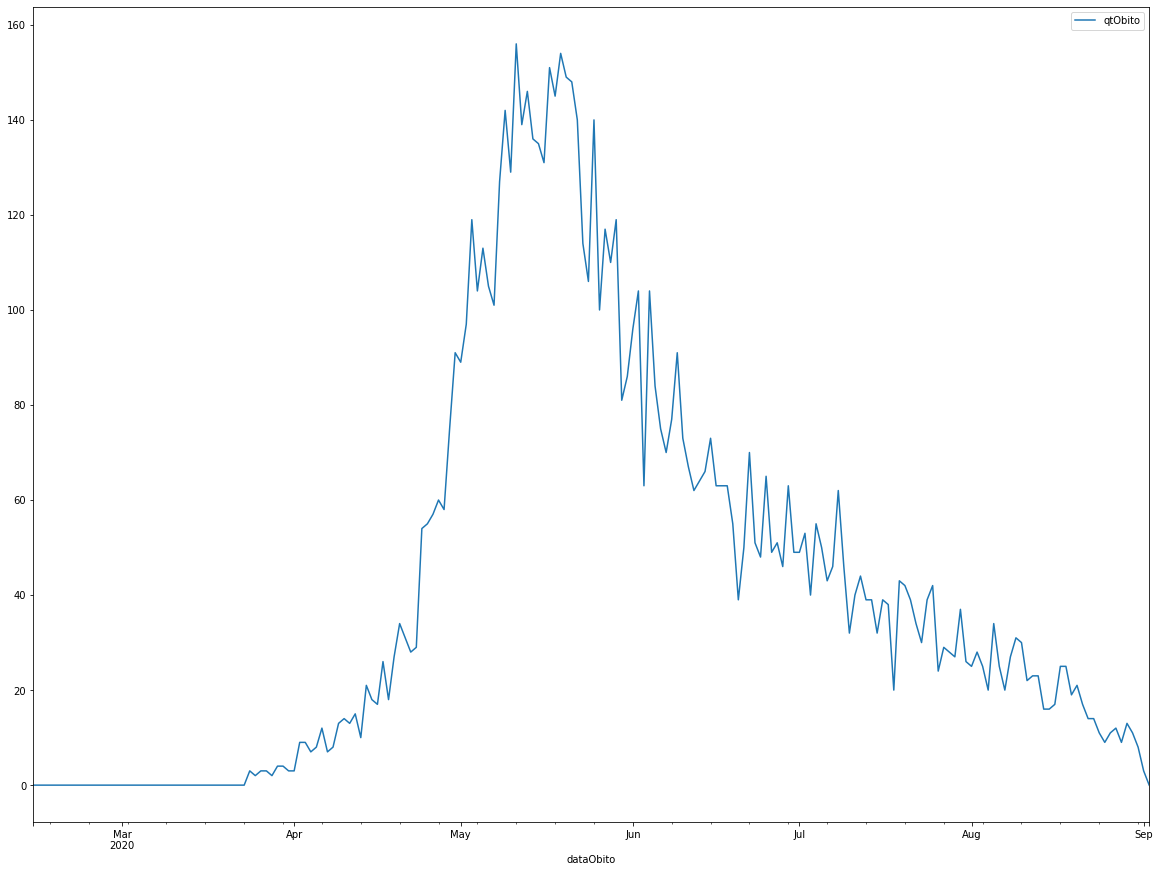

In [172]:
  # agrupar por mes a qtde de obitos e plotar
df_obito.groupby(pd.Grouper(key='dataObito',freq='D')).agg({'qtObito':'sum'}).plot(figsize=(20, 15))

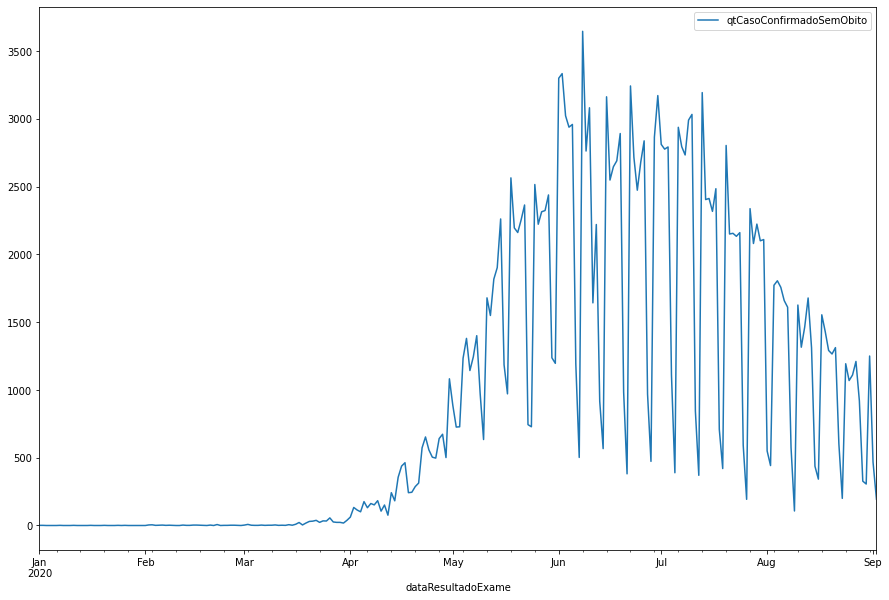

In [173]:
  # agrupar por mes a qtde de casos confirmados SEM óbito e plotar
df_confirmados.groupby(pd.Grouper(key='dataResultadoExame',freq='D')).agg({'qtCasoConfirmadoSemObito':'sum'}).plot(figsize=(15, 10))

**Preparar para plotagem somente de casos confirmados**

In [174]:
group_confirmados = df_confirmados.groupby(by=df_confirmados['dataResultadoExame'].dt.date).count()
df_confir_graf = group_confirmados['dataResultadoExame']

**Gráfico número de casos confirmados por dia**

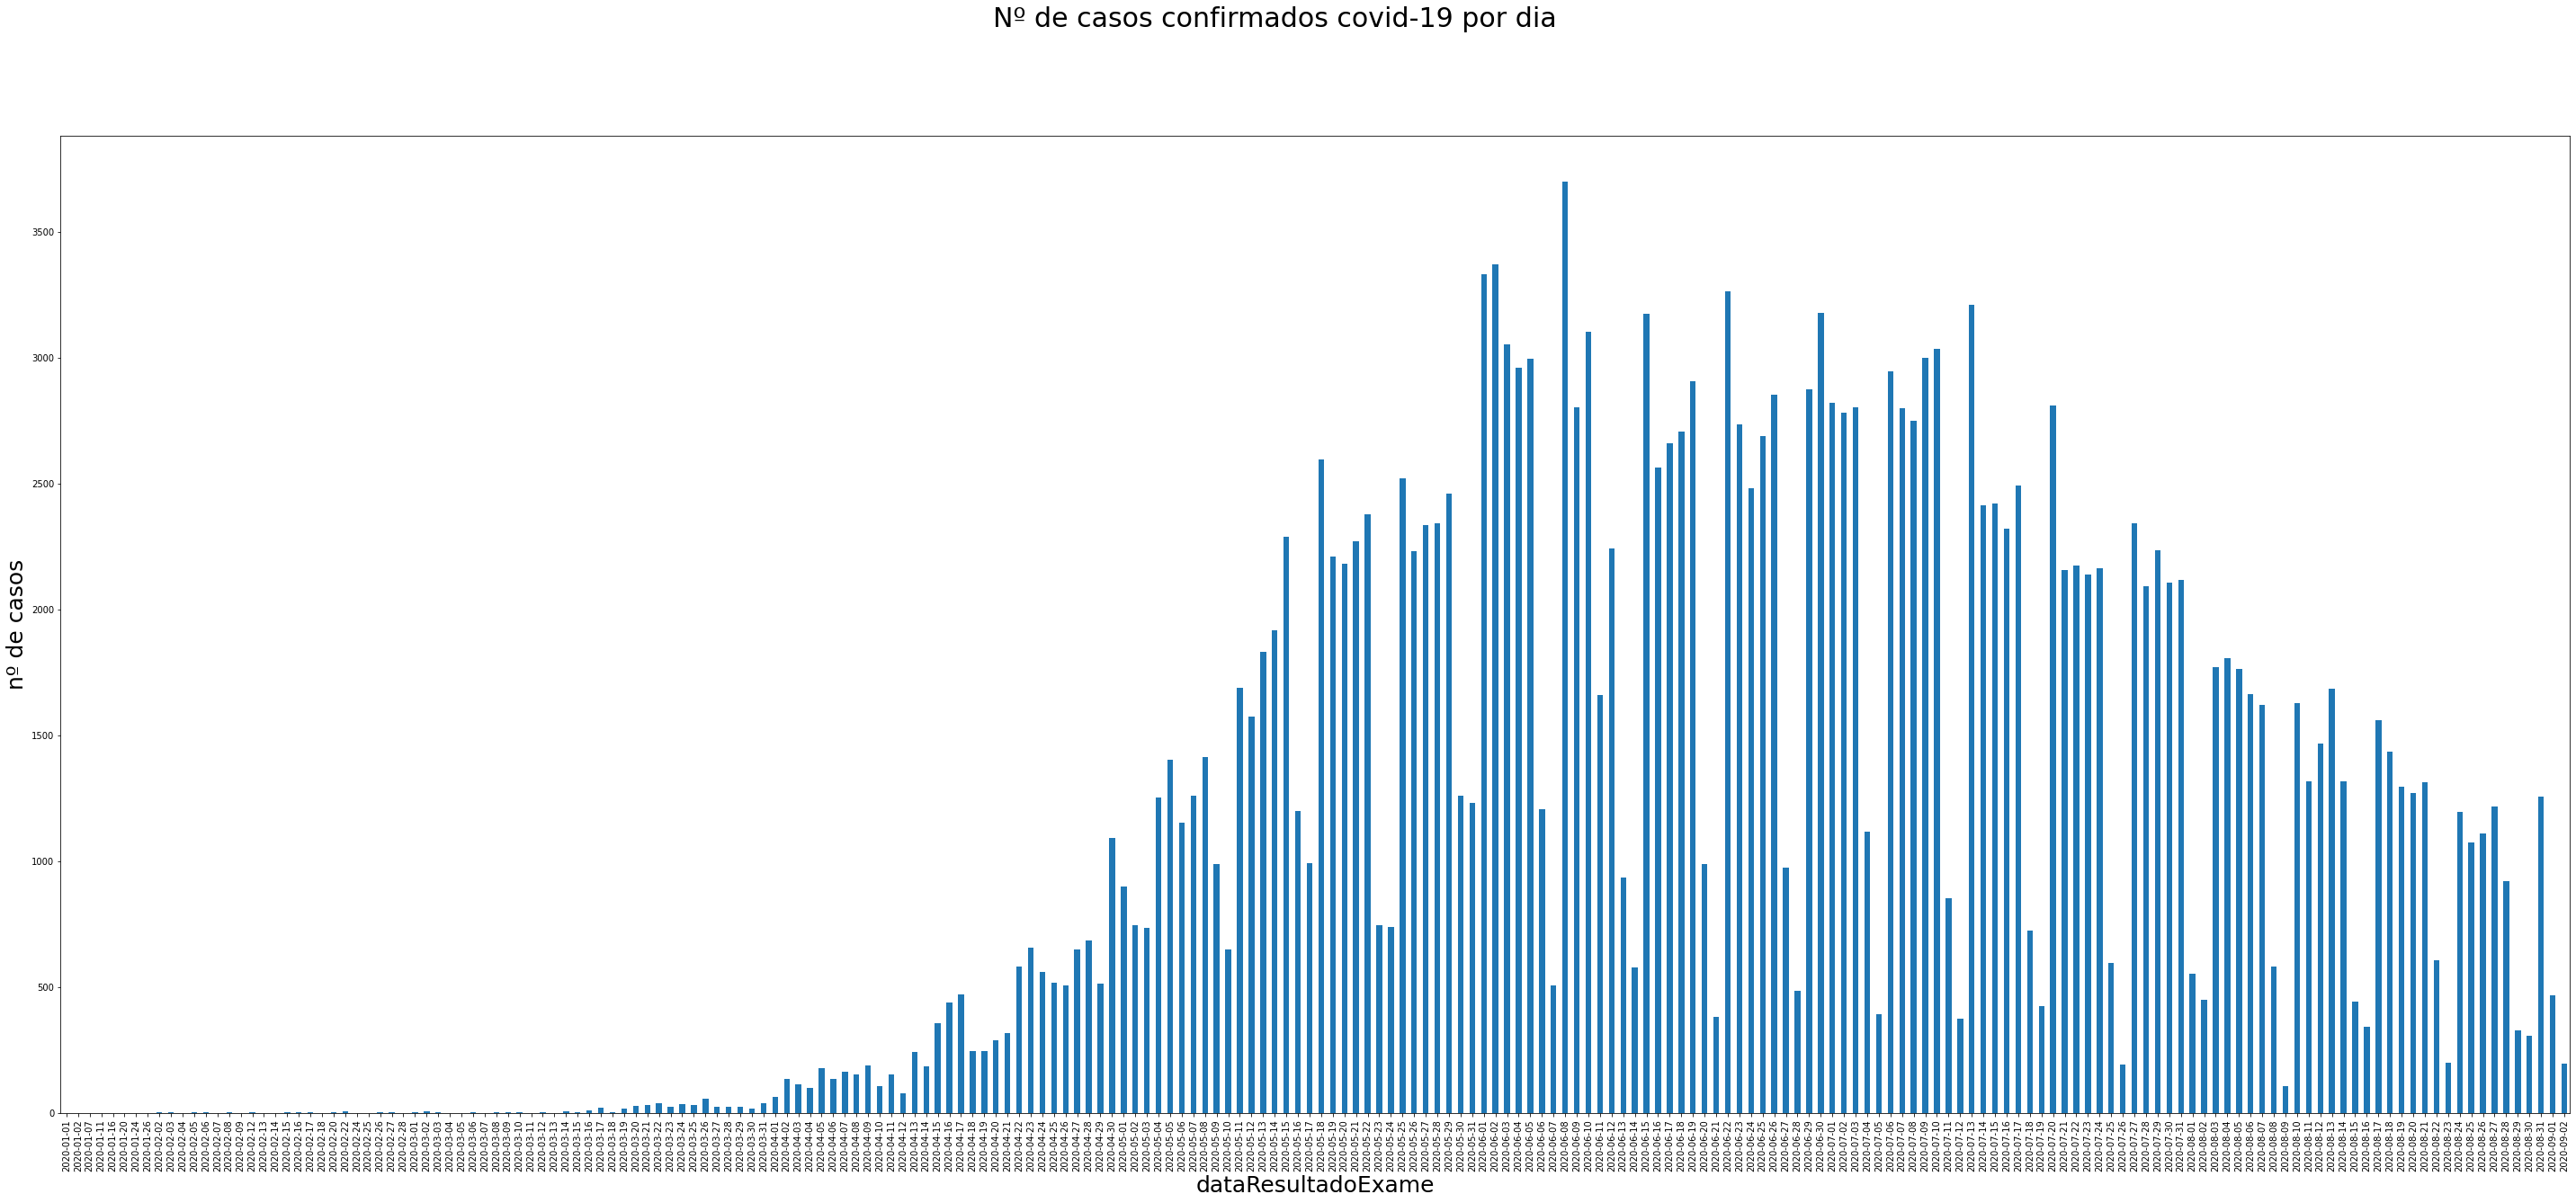

In [175]:
plt.xlabel('Data resultado do exame', fontsize=25) 
plt.ylabel('nº de casos', fontsize=25)
plt.suptitle('Nº de casos confirmados covid-19 por dia', fontsize=30)

df_confir_graf.plot(figsize=(50, 20), kind='bar')

**Preparar para plotagem somente dos óbitos**


In [176]:
group_obito = df_obito.groupby(by=df_obito['dataObito'].dt.date).count()
group_obito

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
dataObito,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-14,1,1,0,1,1,1,1,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1
2020-03-02,1,1,0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1
2020-03-18,1,1,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1
2020-03-21,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1
2020-03-22,2,2,2,2,2,2,2,2,2,0,2,2,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-29,19,19,14,19,19,19,12,19,18,11,6,10,19,18,14,13,19,8,8,7,5,2,7,7,2,5,2,2,2,3,2,2,2,2,3,0,0,19,19,19,19,6,6,19,19,18
2020-08-30,19,19,11,19,19,19,14,19,18,14,11,14,18,17,13,16,19,8,7,8,7,3,5,5,0,1,0,0,0,2,0,0,0,0,0,0,0,19,19,19,19,9,10,19,19,17
2020-08-31,13,13,9,13,13,13,10,13,13,9,9,8,13,10,11,10,13,6,5,6,4,3,4,4,2,2,2,2,2,3,2,2,2,2,2,0,0,13,13,13,13,7,7,13,13,13


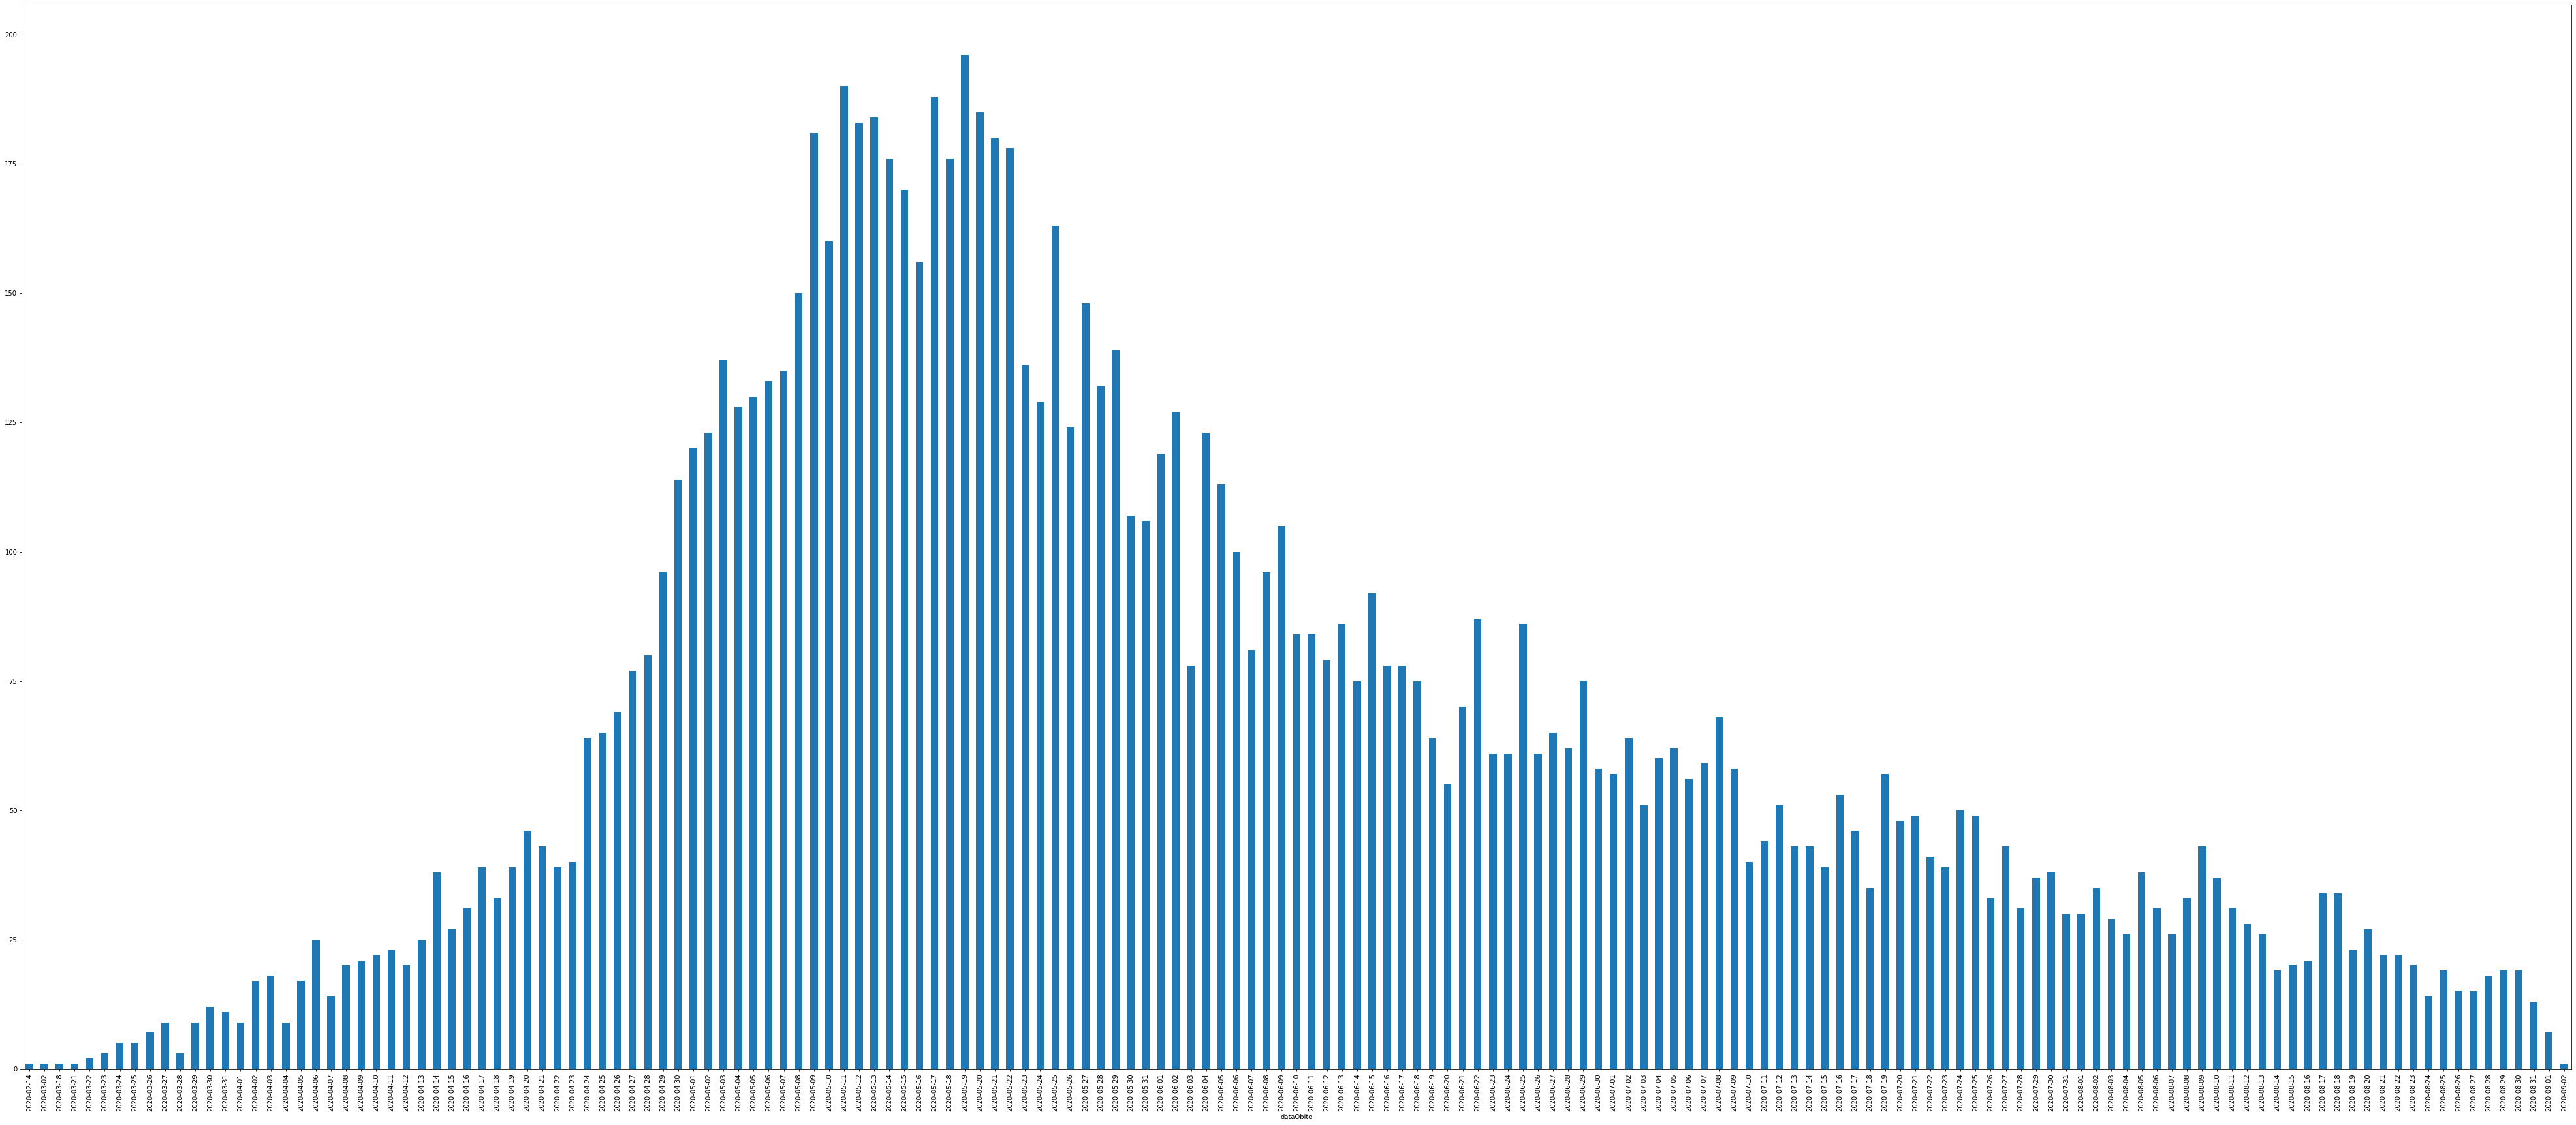

In [177]:
df_ob_graf = group_obito['dataObito']
df_ob_graf.plot(figsize=(70, 30), kind='bar')

In [178]:
group_faixa_idade_obito = df_obito.groupby(by=df_obito['faixaIdade']).count()
group_faixa_idade_obito

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito
faixaIdade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-9,25,25,14,25,25,25,20,25,25,17,16,18,25,24,16,21,25,10,9,10,2,1,8,8,2,2,2,2,2,2,4,2,2,2,2,0,0,25,25,25,25,8,10,25,25
10-19,42,42,27,42,42,42,34,42,42,26,25,29,41,41,30,32,42,19,18,17,11,3,19,19,5,5,5,6,5,5,7,5,5,5,5,0,0,42,42,42,42,16,19,42,42
20-39,446,446,338,446,445,446,364,446,446,318,252,315,424,430,347,371,446,269,254,242,137,69,246,237,71,86,70,70,74,92,71,70,77,74,82,0,0,446,446,446,446,143,184,446,446
40-59,1761,1761,1336,1759,1759,1761,1475,1761,1761,1324,1048,1254,1617,1655,1499,1511,1761,1107,1045,960,477,268,1042,1021,351,494,366,368,368,533,370,377,378,374,389,0,0,1761,1761,1761,1761,581,763,1761,1761
60-79,4508,4508,3465,4507,4506,4507,3826,4508,4508,3427,2743,3328,4167,4273,3920,3886,4508,2901,2748,2477,1131,614,2731,2658,982,1563,1007,1001,998,1543,1045,1030,1011,1034,1003,0,0,4508,4508,4508,4508,1586,2011,4508,4508
80E+,3416,3416,2534,3416,3416,3416,2819,3416,3416,2622,2037,2532,3149,3225,2841,2978,3416,2147,2022,1701,610,278,2018,1981,668,1182,671,670,671,1007,757,697,664,689,661,0,0,3416,3416,3416,3416,1204,1484,3416,3416


In [179]:
counts_obitos_faixa_idade = df_obito.groupby(['faixaIdade', 'sexoPaciente']).faixaIdade.count().unstack()
counts_obitos_faixa_idade

sexoPaciente,FEMININO,MASCULINO
faixaIdade,,
0-9,12,13
10-19,16,26
20-39,179,267
40-59,656,1105
60-79,1894,2614
80E+,1633,1783


**Gerando gráfico de óbitos por faixa de idade**

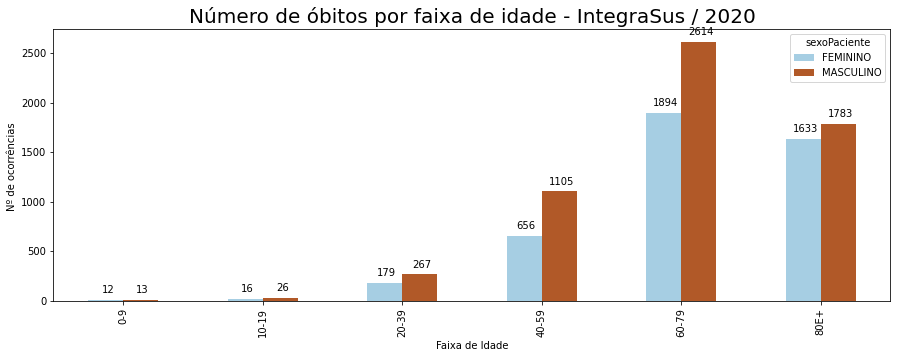

In [180]:
ax = counts_obitos_faixa_idade.plot(kind='bar',stacked = False, colormap = 'Paired', figsize=(15, 5) )

for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0).astype(np.int64), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(2, 10), textcoords='offset points')

plt.xlabel ('Faixa de Idade')
plt.ylabel ('Nº de ocorrências ')
plt.title('Número de óbitos por faixa de idade - IntegraSus / 2020',fontsize=20)
plt.show()

**Distribuição de ocorrências de óbito por faixa de idade no CE**


In [181]:
group_faixa_idade_obito = df_obito.groupby('faixaIdade')
group_faixa_idade_obito['faixaIdade'].count()

faixaIdade
0-9        25
10-19      42
20-39     446
40-59    1761
60-79    4508
80E+     3416
Name: faixaIdade, dtype: int64

**Gráfico : Ocorrências de óbito por sexo do paciente.**

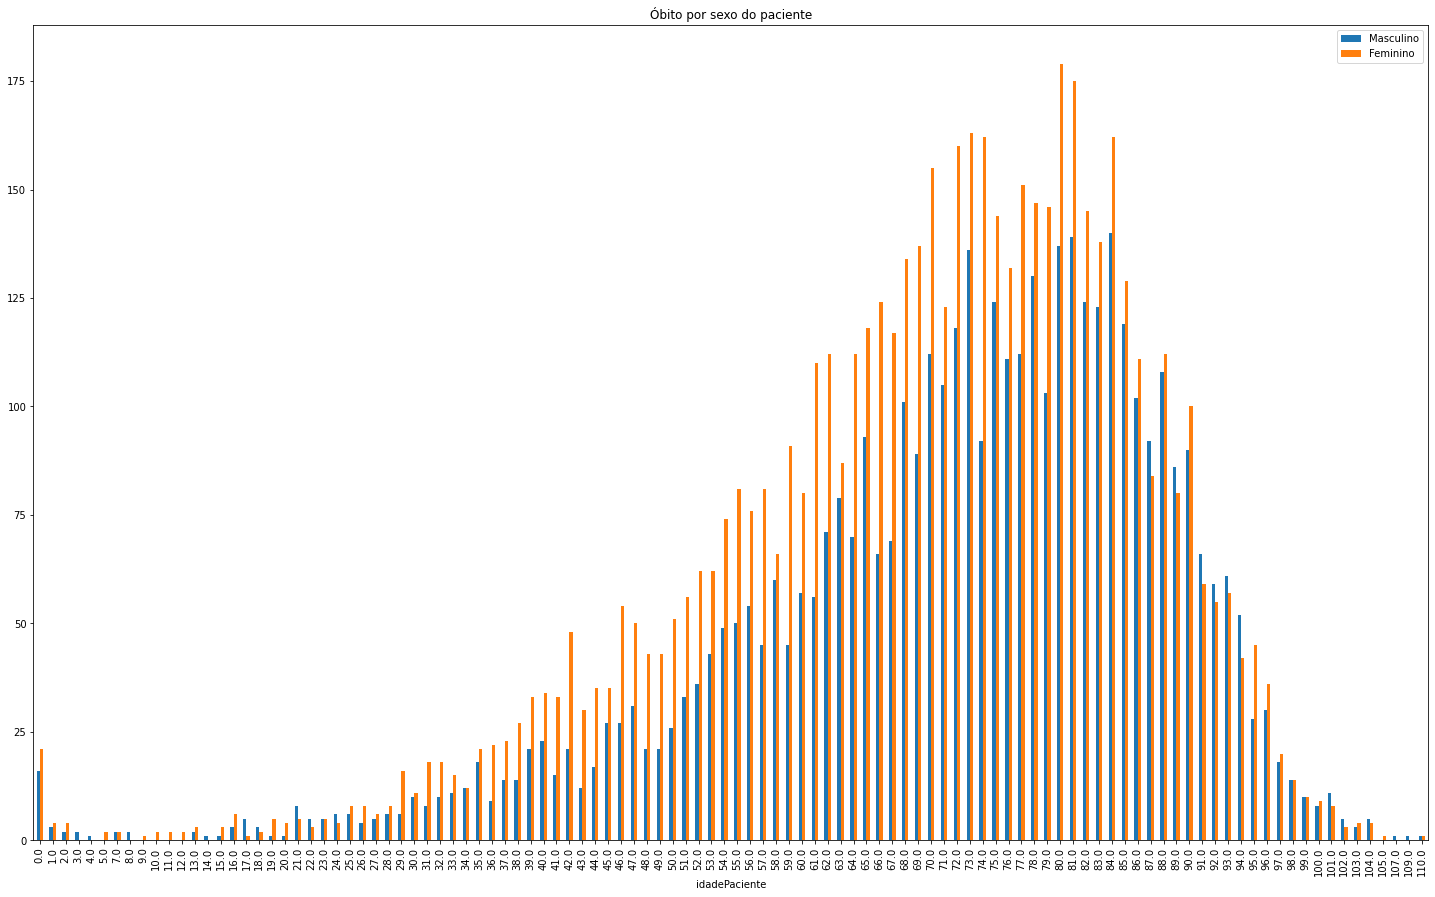

In [182]:
obito_by_sex = df_obito.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
obito_by_sex.columns = ['Masculino', 'Feminino']
obito_by_sex.plot.bar(title='Óbito por sexo do paciente', figsize=(25,15) )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8707e32e8>,
      dtype=object)

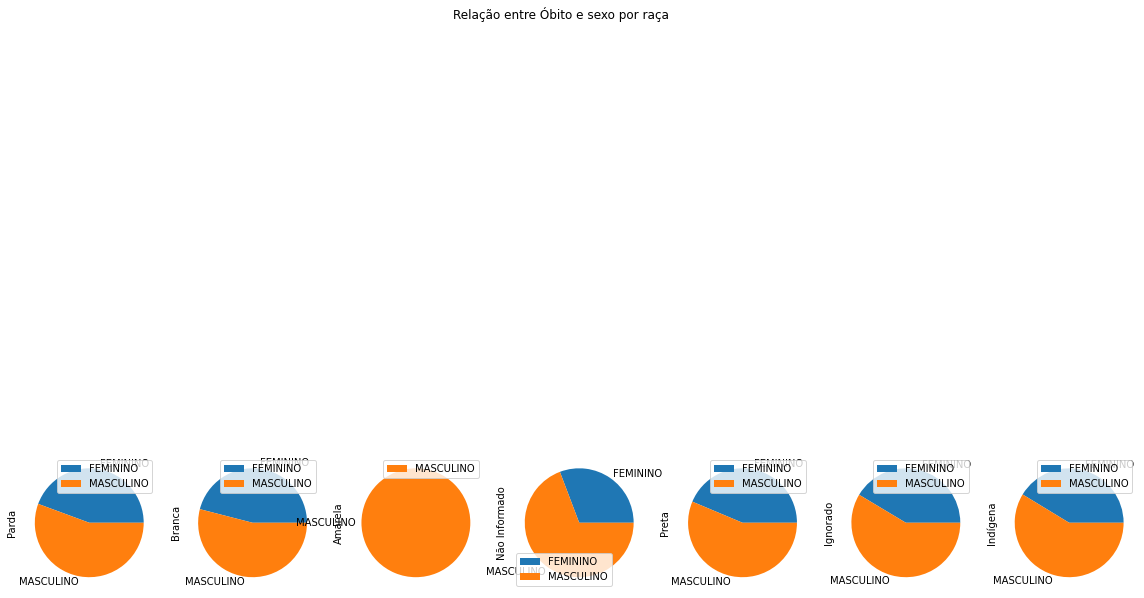

In [183]:
obito_by_sexo = df_obito.groupby([ 'sexoPaciente', 'racaCorPaciente']).size().unstack('racaCorPaciente')
obito_by_sexo.columns =  ['Parda','Branca','Amarela', 'Não Informado','Preta','Ignorado','Indígena']
obito_by_sexo.plot.pie(title='Relação entre Óbito e sexo por raça', figsize=(20,15) , subplots = True  )

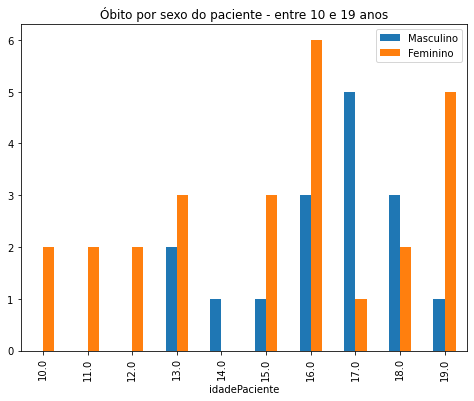

In [184]:
df_obit_faixa1 = df_obito.loc[ (df_obito['faixaIdade'] == '10-19')]
df_obit_plot_faixa1 = df_obit_faixa1.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa1.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa1.plot.bar(title='Óbito por sexo do paciente - entre 10 e 19 anos', figsize=(8,6) )

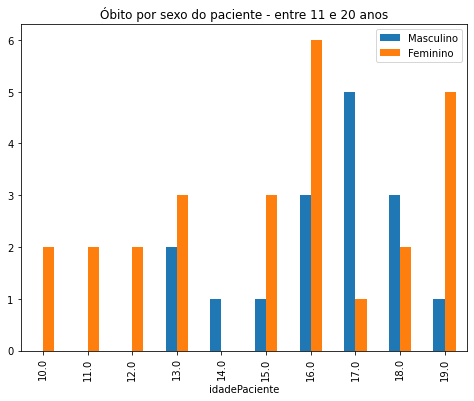

In [185]:
df_obit_faixa2 = df_obito.loc[ (df_obito['faixaIdade'] == '10-19')]
df_obit_plot_faixa2 = df_obit_faixa2.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa2.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa2.plot.bar(title='Óbito por sexo do paciente - entre 11 e 20 anos', figsize=(8,6) )

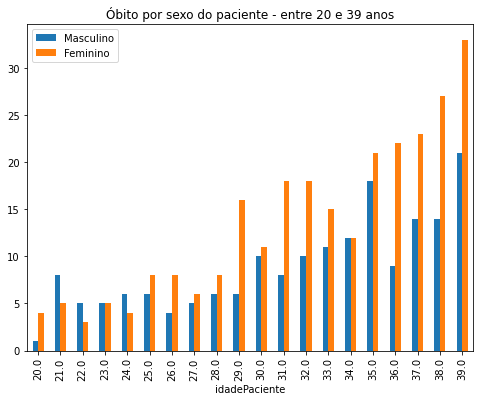

In [189]:
df_obit_faixa3 = df_obito.loc[ (df_obito['faixaIdade'] == '20-39')]
df_obit_plot_faixa3 = df_obit_faixa3.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa3.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa3.plot.bar(title='Óbito por sexo do paciente - entre 20 e 39 anos', figsize=(8,6) )

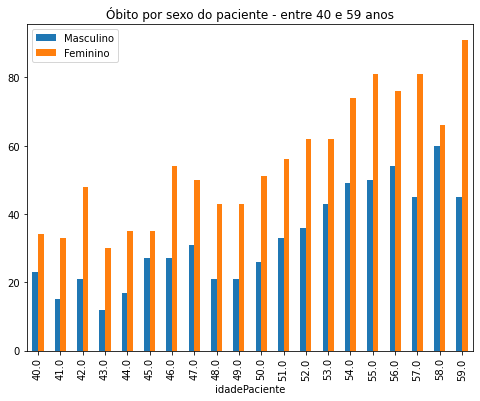

In [190]:
df_obit_faixa4 = df_obito.loc[ (df_obito['faixaIdade'] == '40-59')]
df_obit_plot_faixa4 = df_obit_faixa4.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa4.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa4.plot.bar(title='Óbito por sexo do paciente - entre 40 e 59 anos', figsize=(8,6) )

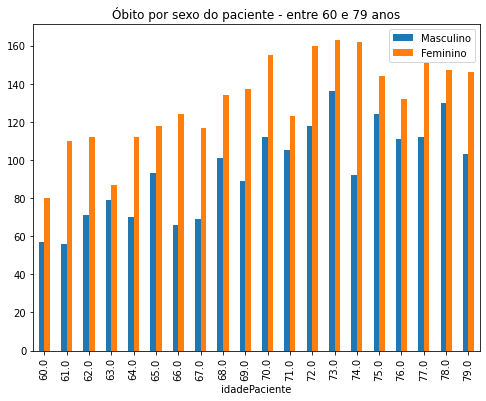

In [191]:
df_obit_faixa5 = df_obito.loc[ (df_obito['faixaIdade'] == '60-79')]
df_obit_plot_faixa5 = df_obit_faixa5.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa5.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa5.plot.bar(title='Óbito por sexo do paciente - entre 60 e 79 anos', figsize=(8,6) )

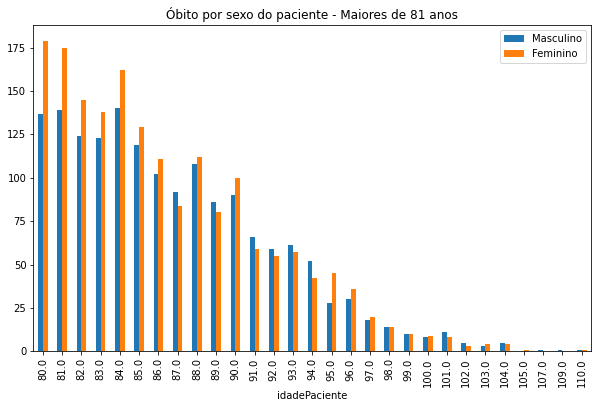

In [193]:
df_obit_faixa9 = df_obito.loc[ (df_obito['faixaIdade'] == '80E+')]
df_obit_plot_faixa9 = df_obit_faixa9.groupby(['idadePaciente', 'sexoPaciente']).size().unstack('sexoPaciente')
df_obit_plot_faixa9.columns = ['Masculino', 'Feminino']
df_obit_plot_faixa9.plot.bar(title='Óbito por sexo do paciente - Maiores de 81 anos', figsize=(10,6) )

# **Gerar dataframe somente para a cidade de Fortaleza**

In [195]:
df.head(3)

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
0,0,4b672a7843721a0019381cc839fcd71a,NaN,CE,231090.0,PIQUET CARNEIRO,DISTRITO IBICUA,MASCULINO,43.0,2020-07-09,NaT,NaT,NaT,NaN,NaN,2020-07-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,6389090,PIQUET CARNEIRO,0,0,40-59
1,1,88afda26fcf0146e14b04daadbb71d3f,NaN,CE,230500.0,GUARACIABA DO NORTE,ZONA RURAL,FEMININO,3.0,2020-08-05,NaT,NaT,NaT,NaN,NaN,2020-08-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2561344,GUARACIABA DO NORTE,0,0,0-9
2,2,2e4b50fb6e54d98c210d335ca9652676,NaN,CE,230680.0,JAGUARIBARA,CONJ FELICIA,FEMININO,16.0,2020-07-29,NaT,NaT,NaT,NaN,NaN,2020-07-26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não Informado,Parda,NaT,2527677,JAGUARIBARA,0,0,10-19


In [196]:
df_fortaleza =  df[df['municipioPaciente'] == 'FORTALEZA']

In [197]:
df_fortaleza.head(3)

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
3,3,307e78273c1f690632ddddaf4366c713,NaN,CE,230440.0,FORTALEZA,CONJUNTO PALMEIRAS,MASCULINO,61.0,2020-07-29,2020-07-29,2020-07-31 16:06:00,2020-07-29,Negativo,NaN,2020-07-29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Parda,NaT,7429398,FORTALEZA,0,0,60-79
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26 00:00:00,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59
7,7,f633b38785e0bbb0da5064d311ec174d,NaN,CE,230440.0,FORTALEZA,CAMBEBA,FEMININO,48.0,2020-05-21,NaT,2020-05-25 00:00:00,2020-05-22,Positivo,NaN,2020-05-18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Amarela,NaT,3012778,FORTALEZA,0,1,40-59


In [198]:
# Gerar dataset somente com óbitos de Fortaleza
df_obito_fortaleza = df_fortaleza.loc[df_fortaleza['dataObito'].notnull()  ] 
df_obito_fortaleza

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
196,196,e49ca4b4153fee1ca1955086e46194a7,NaN,CE,230440.0,FORTALEZA,CRISTO REDENTOR,MASCULINO,54.0,2020-05-15,2020-05-15,2020-06-02 17:14:31,2020-05-15 06:00:00,Negativo,NaN,2020-05-12,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-06-11 09:38:45.110,7434308,FORTALEZA,0,0,40-59
3101,3101,fa3adc9141a51fc6c5073da8eda84beb,BRASIL,CE,230440.0,FORTALEZA,PLANALTO AYRTON SENA,MASCULINO,61.0,2020-05-31,NaT,NaT,2020-06-03 06:00:00,Positivo,True,2020-05-19,2020-06-15,3.159118e+11,Em Análise,2020-05-31 00:00:00.000,NaN,NaN,Óbito,2020-06-15 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRAG Teste Rápido +,Teste Rápido,Não Informado,2020-06-17 09:58:48.453,NaN,FORTALEZA,1,0,60-79
3750,3750,4e547c41d61884acbce4cb4ba0b5570b,NaN,CE,230440.0,FORTALEZA,NaN,FEMININO,83.0,NaT,NaT,2020-07-28 00:00:00,2020-07-26 03:00:00,Negativo,NaN,2020-07-25,2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Não Informado,2020-08-11 14:05:13.177,NaN,NaN,0,0,80E+
4838,4838,152fd68edcc6ee699df8a2ed16c8c433,BRASIL,CE,230440.0,FORTALEZA,SAO JOAO DO TAUAPE,MASCULINO,72.0,2020-05-06,2020-05-06,NaT,2020-05-06 09:00:00,NaN,False,2020-04-22,2020-05-09,3.159300e+11,Em Análise,2020-05-04 00:00:00.000,NaN,NaN,Óbito,2020-05-09 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em investigação,Não Informado,Parda,2020-05-20 17:36:38.930,9526293,FORTALEZA,0,0,60-79
5042,5042,3da16ad50ec76f362f9330f3c15b34a5,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,65.0,2020-04-27,2020-04-27,2020-05-01 20:41:01,2020-04-27 06:00:00,Negativo,NaN,2020-04-22,2020-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-05-20 17:29:50.957,7993218,FORTALEZA,0,0,60-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757260,757260,3ed1260951d20f926b71fbec58376ece,BRASIL,CE,230440.0,FORTALEZA,NaN,FEMININO,72.0,NaT,2020-06-09,2020-06-11 10:43:26,2020-06-09 03:00:00,Negativo,NaN,NaT,2020-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Não Informado,2020-06-17 18:47:41.967,NaN,NaN,0,0,60-79
758841,758841,f2b53bb1faf59d710e4a9be5ec11f4bb,NaN,CE,230440.0,FORTALEZA,NaN,FEMININO,81.0,2020-04-28,2020-04-29,2020-05-05 17:00:09,2020-04-28 03:00:00,Negativo,NaN,2020-04-22,2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-05-20 17:34:35.813,2527057,FORTALEZA,0,0,80E+
760665,760665,5527aae144ee27baa9146d16d66e5c48,NaN,CE,230440.0,FORTALEZA,MONTESE,MASCULINO,88.0,2020-08-02,2020-08-02,2020-08-04 12:22:53,2020-08-03 03:00:00,Negativo,NaN,2020-08-02,2020-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Descartado,RT PCR,Parda,2020-08-17 14:02:12.800,7514948,FORTALEZA,0,0,80E+
760833,760833,7f0a3470a831a43ae84d09c23142decb,BRASIL,C

In [199]:
# Gerar dataset somente com casos confirmados que não resultaram em óbito
df_confirmados = df[ (df['resultadoFinalExame'] == 'Positivo') & (df['evolucaoCasoSivep'] != 'Óbito' ) ]
df_confirmados.head()

,Unnamed: 0,codigoPaciente,paisPaciente,estadoPaciente,codigoMunicipioPaciente,municipioPaciente,bairroPaciente,sexoPaciente,idadePaciente,dataNotificacao,dataSolicitacaoExame,dataResultadoExame,dataColetaExame,resultadoFinalExame,obitoConfirmado,dataInicioSintomas,dataObito,idSivep,classificacaoEstadoSivep,dataInternacaoSivep,dataEntradaUtisSvep,dataSaidaUtisSvep,evolucaoCasoSivep,dataEvolucaoCasoSivep,comorbidadePuerperaSivep,comorbidadeCardiovascularSivep,comorbidadeHematologiaSivep,comorbidadeSindromeDownSivep,comorbidadeAsmaSivep,comorbidadeDiabetesSivep,comorbidadeNeurologiaSivep,comorbidadePneumopatiaSivep,comorbidadeImunodeficienciaSivep,comorbidadeRenalSivep,comorbidadeObesidadeSivep,comorbidadeHiv,comorbidadeNeoplasias,tipoObito,tipoTesteExame,racaCorPaciente,dataNotificacaoObito,cnesNotificacaoEsus,municipioNotificacaoEsus,qtObito,qtCasoConfirmadoSemObito,faixaIdade
4,4,95b593cbc10dbdd49540334b4a222824,NaN,CE,230440.0,FORTALEZA,PASSARE,MASCULINO,40.0,2020-04-23,NaT,2020-04-26,NaT,Positivo,NaN,2020-04-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,3394514,FORTALEZA,0,1,40-59
7,7,f633b38785e0bbb0da5064d311ec174d,NaN,CE,230440.0,FORTALEZA,CAMBEBA,FEMININO,48.0,2020-05-21,NaT,2020-05-25,2020-05-22,Positivo,NaN,2020-05-18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Amarela,NaT,3012778,FORTALEZA,0,1,40-59
10,10,99d0d41c7b822ba907e71edd4b1ed255,NaN,CE,231095.0,PIRES FERREIRA,MARROCOS,FEMININO,3.0,2020-08-24,NaT,2020-08-25,2020-08-25,Positivo,NaN,2020-08-12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,6614221,PIRES FERREIRA,0,1,0-9
16,16,d732bc739e8a931f25d4e76525ce1f9b,NaN,CE,230290.0,CAPISTRANO,ZONA RURAL,FEMININO,28.0,2020-08-05,NaT,2020-08-11,2020-08-11,Positivo,NaN,2020-08-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Teste Rápido,Parda,NaT,\t2327872,CAPISTRANO,0,1,20-39
19,19,6bbbd16692086a4e7ccf0748eb6f3e56,NaN,CE,230440.0,FORTALEZA,MEIRELES,MASCULINO,47.0,2020-05-03,NaT,2020-05-09,2020-05-07,Positivo,NaN,2020-04-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT PCR,Branca,NaT,980016277569495,FORTALEZA,0,1,40-59


In [200]:
 # Método 01 de contagem por faixa de idade
 # Contagem de óbitos por faixa etária em Fortaleza
 df_obito_fortaleza.groupby(['faixaIdade','sexoPaciente']).size()

faixaIdade  sexoPaciente
0-9         FEMININO           3
            MASCULINO          2
10-19       FEMININO           5
            MASCULINO          9
20-39       FEMININO          74
            MASCULINO        105
40-59       FEMININO         315
            MASCULINO        554
60-79       FEMININO         873
            MASCULINO       1219
80E+        FEMININO         747
            MASCULINO        686
dtype: int64

In [201]:
 # Método 02 de contagem por faixa de idade
 # Contagem de óbitos por faixa etária em Fortaleza
group_faixa_idade_obito_fortaleza = df_obito_fortaleza.groupby(['faixaIdade','sexoPaciente'])
group_faixa_idade_obito_fortaleza['faixaIdade'].count()

faixaIdade  sexoPaciente
0-9         FEMININO           3
            MASCULINO          2
10-19       FEMININO           5
            MASCULINO          9
20-39       FEMININO          74
            MASCULINO        105
40-59       FEMININO         315
            MASCULINO        554
60-79       FEMININO         873
            MASCULINO       1219
80E+        FEMININO         747
            MASCULINO        686
Name: faixaIdade, dtype: int64

In [204]:
group_obitos_bairro = df_obito_fortaleza.groupby('bairroPaciente')
group_obitos_bairro['bairroPaciente'].count()

bairroPaciente
 CARLITO PAMPLONA          1
 CONJUNTO SÃO CRISTÓVÃO    1
 JANGURUSSU                1
 JARDIM DAS OLIVEIRAS      1
 JOAQUIM TAVORA            1
                          ..
VL PERI                    1
VOLA UNIAO                 1
VOLTA DA BOA VISTA         1
WEYNE                      1
ÁLVARO WEYNE               2
Name: bairroPaciente, Length: 484, dtype: int64

In [205]:
cont_idade_sexo_fortaleza = df_obito_fortaleza.groupby(['faixaIdade','sexoPaciente']).faixaIdade.count().unstack()
print(cont_idade_sexo_fortaleza)

sexoPaciente  FEMININO  MASCULINO
faixaIdade                       
0-9                  3          2
10-19                5          9
20-39               74        105
40-59              315        554
60-79              873       1219
80E+               747        686


In [212]:
cont_idade_sexo_fortaleza

sexoPaciente,FEMININO,MASCULINO
faixaIdade,,
0-9,3,2
10-19,5,9
20-39,74,105
40-59,315,554
60-79,873,1219
80E+,747,686


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa86fd36da0>,
      dtype=object)

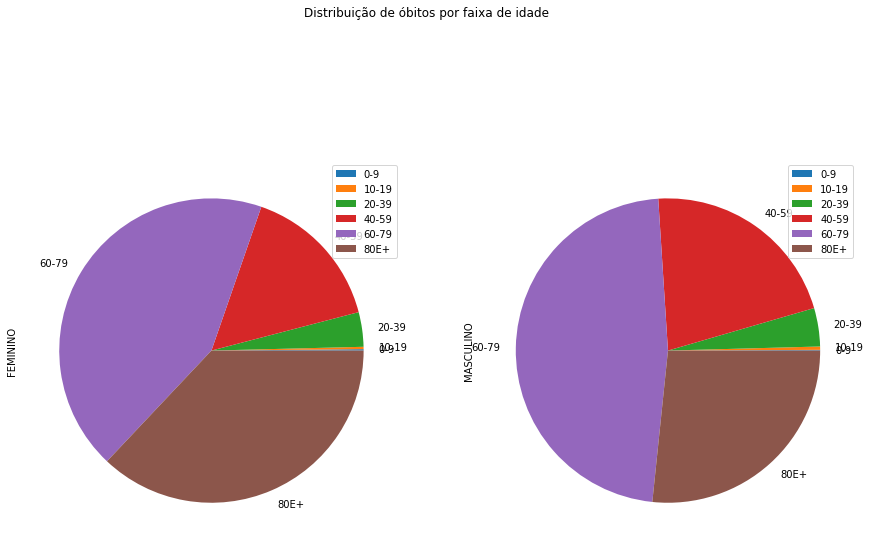

In [211]:
cont_idade_sexo_fortaleza.plot(kind='pie',  figsize=(15,10), title= "Distribuição de óbitos por faixa de idade", subplots = True  )